In [25]:
# Import Library
from keras.utils import np_utils
import cv2
import numpy as np
import time
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 18
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, History, ReduceLROnPlateau, CSVLogger
from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import datetime as dt
import h5py

%matplotlib inline


In [2]:
# Data Directory Setup
train_dir = './train/'
test_dir = './test/'

In [3]:
# Data Exploration
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
no_categories = len(categories)
print ("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print ("The number of category is {}".format(no_categories))
print ("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print ("Here are the training data intel:")

for cat in categories:
    print('-{} {} images'.format(cat, len(os.listdir(os.path.join(train_dir, cat)))))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The number of category is 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Here are the training data intel:
-Black-grass 263 images
-Charlock 390 images
-Cleavers 287 images
-Common Chickweed 611 images
-Common wheat 221 images
-Fat Hen 475 images
-Loose Silky-bent 654 images
-Maize 221 images
-Scentless Mayweed 516 images
-Shepherds Purse 231 images
-Small-flowered Cranesbill 496 images
-Sugar beet 385 images


In [4]:
# Create Training Data DataFrame
def create_training_df(train_dir, categories):
    train = []
    for cat_id, cat in enumerate(categories):
        for file in os.listdir(os.path.join(train_dir, cat)):
            train.append([train_dir + '{}/{}'.format(cat, file), cat_id, cat])
    train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])

    return train

In [5]:
# Show Training Data DataFrame
train_df = create_training_df(train_dir, categories)
print ("There are {} training items".format(len(train_df)))
train_df.head(10)


There are 4750 training items


,file,category_id,category
0,./train/Black-grass/e47987eab.png,0,Black-grass
1,./train/Black-grass/7b72b398d.png,0,Black-grass
2,./train/Black-grass/f4b7ddbce.png,0,Black-grass
3,./train/Black-grass/6e193f1bb.png,0,Black-grass
4,./train/Black-grass/c025e2886.png,0,Black-grass
5,./train/Black-grass/686132594.png,0,Black-grass
6,./train/Black-grass/ac47ebc4d.png,0,Black-grass
7,./train/Black-grass/3a8c485bc.png,0,Black-grass
8,./train/Black-grass/957b8523c.png,0,Black-grass
9,./train/Black-grass/4a3b96198.png,0,Black-grass


In [7]:
# Create Testing Data DataFrame
def create_testing_df(test_dir):
    test = []
    for file in os.listdir(test_dir):
        test.append([test_dir+file])
    test = pd.DataFrame(test, columns=['file'])

    return test

In [8]:
# Show Testing Data DataFrame
test_df = create_testing_df(test_dir)
print ("There are {} testing items".format(len(test_df)))
test_df.head(10)

There are 794 testing items


,file
0,./test/77ccb8b2a.png
1,./test/3b73c3b61.png
2,./test/dc55449b2.png
3,./test/da4ed3a28.png
4,./test/8ab8a958b.png
5,./test/e5e3dccff.png
6,./test/659412b1a.png
7,./test/e5064f6be.png
8,./test/03a2ee656.png
9,./test/ef74dbcad.png


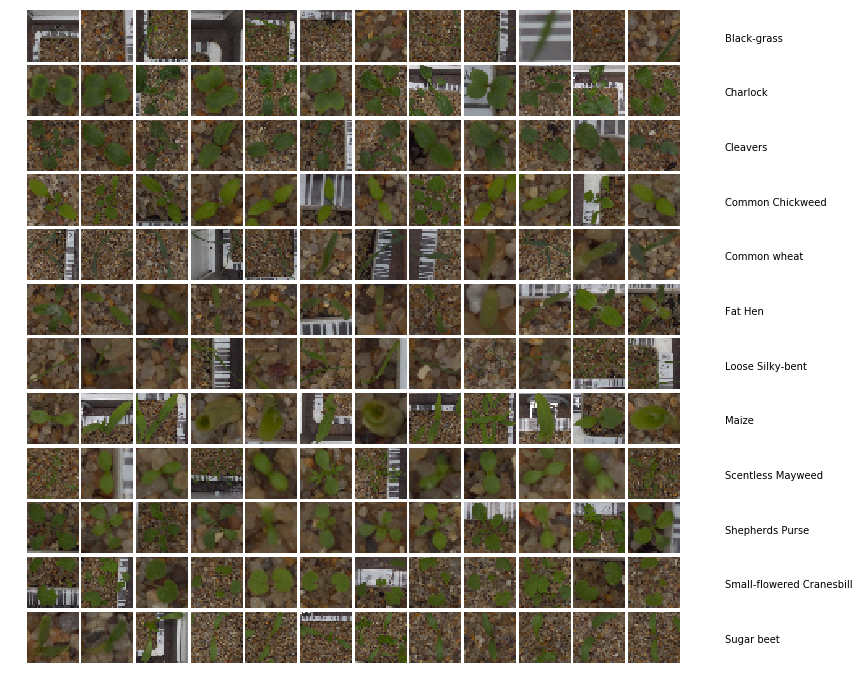

In [9]:
# Showing Image Data
# Credit to Kaggler - beluga (https://www.kaggle.com/gaborfodor/seedlings-pretrained-keras-models)
fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(no_categories, no_categories), axes_pad=0.05)
i = 0
for category_id, category in enumerate(categories):
    for filepath in train_df[train_df['category'] == category]['file'].values[:no_categories]:
        ax = grid[i]
        img = cv2.imread(filepath)
        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % no_categories == no_categories - 1:
            ax.text(60, 17, filepath.split('/')[2], verticalalignment='center')
        i += 1
plt.show();

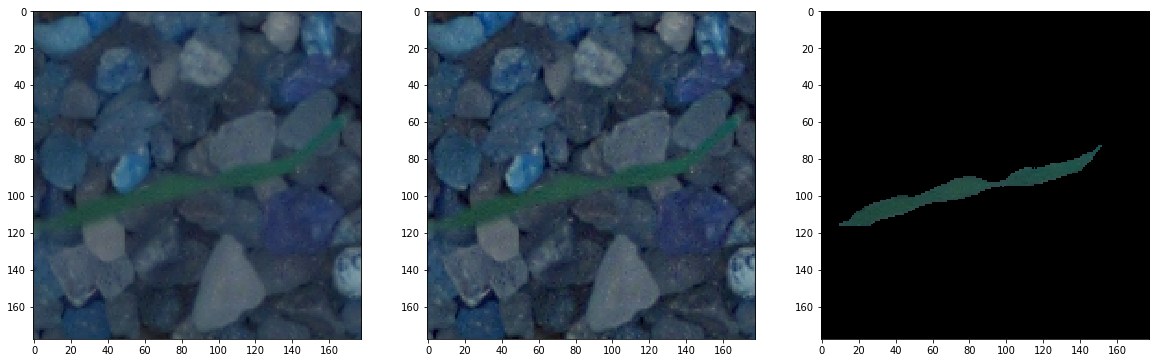

In [10]:
# Using opencv to output segmented image that removed the image background
def create_segmented_image(img):
    blurr = cv2.GaussianBlur(img,(5,5),0)
    hsv = cv2.cvtColor(blurr, cv2.COLOR_BGR2HSV)
    
    sensitivity = 30
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
    
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    masked = mask > 0
    preprocessed = np.zeros_like(img,np.uint8)
    preprocessed[masked] = img[masked]

    return np.asarray(preprocessed)

# Blurring the image
def blur(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

img = cv2.imread('./train/Black-grass/ac47ebc4d.png')
blurr = blur(img)
segment = create_segmented_image(img)

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(img)
axs[1].imshow(blurr)
axs[2].imshow(segment)


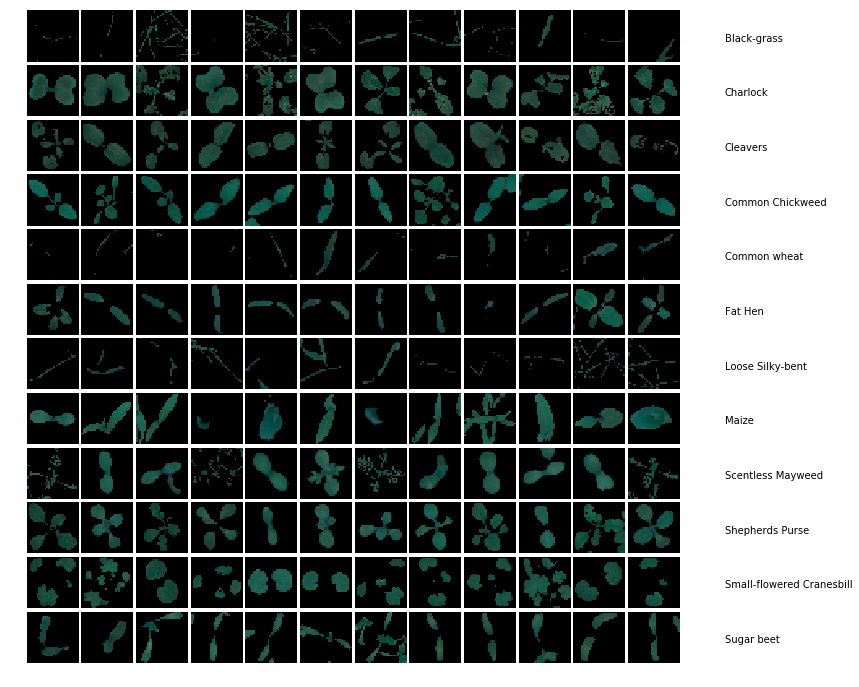

In [11]:
# Showing Preprocessed Image Data
fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(no_categories, no_categories), axes_pad=0.05)
i = 0
for category_id, category in enumerate(categories):
    for filepath in train_df[train_df['category'] == category]['file'].values[:no_categories]:
        ax = grid[i]
        img = cv2.imread(filepath)
        segment = create_segmented_image(img)
        segment = cv2.resize(segment, (32,32))
        ax.imshow(segment)
        ax.axis('off')
        if i % no_categories == no_categories - 1:
            ax.text(60, 17, filepath.split('/')[2], verticalalignment='center')
        i += 1
plt.show();

In [12]:
# Data Shuffling and Splitting
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(10)

,file,category_id,category
0,./train/Maize/9d3514473.png,7,Maize
1,./train/Black-grass/dcbd3fa08.png,0,Black-grass
2,./train/Charlock/c39fea9e3.png,1,Charlock
3,./train/Scentless Mayweed/a390479c5.png,8,Scentless Mayweed
4,./train/Common Chickweed/e231ad747.png,3,Common Chickweed
5,./train/Charlock/ddb90e66a.png,1,Charlock
6,./train/Common Chickweed/cc2a8c766.png,3,Common Chickweed
7,./train/Common Chickweed/518787d0b.png,3,Common Chickweed
8,./train/Loose Silky-bent/80cf1232d.png,6,Loose Silky-bent
9,./train/Sugar beet/9af73f331.png,11,Sugar beet


In [13]:
# Train Valid Data Splitting
np.random.seed(seed=12)
rnd = np.random.random(len(train_df))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
Y_train = train_df.loc[train_idx, 'category_id'].values
Y_valid = train_df.loc[valid_idx, 'category_id'].values
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
len(Y_train), len(Y_valid)

(3800, 950)

In [14]:
# Reading Training Data
def reading_training_data():
    input_size = 299
    X_Data = np.zeros((len(train_df), input_size, input_size, 3), dtype='float32')
    for i, file in tqdm(enumerate(train_df['file'])):
        img = cv2.imread(file)
        segment = create_segmented_image(img)
        segment = cv2.resize(segment, (input_size,input_size))
        X_Data[i] = segment/255.
    print('Train Images shape: {} size: {:,}'.format(X_Data.shape, X_Data.size))
    
    return X_Data

# X_Data = reading_training_data()

# Read Data from h5 format saved previously
def read_train_h5():
    train_h5 = h5py.File('./saved_data/train_valid_masked_299.h5', 'r')
#     train_h5 = h5py.File('./saved_data/train_valid_masked_reduced_lsb.h5', 'r')
    X_train = np.array(train_h5['X_train'][:]) 
    Y_train = np.array(train_h5['Y_train'][:]) 
    X_valid = np.array(train_h5['X_valid'][:]) 
    Y_valid = np.array(train_h5['Y_valid'][:]) 
    return X_train, Y_train, X_valid, Y_valid

X_train, Y_train, X_valid, Y_valid = read_train_h5()

In [15]:
# Spliting Training Data
def split_training_data():
    X_train = X_Data[train_idx]
    X_valid = X_Data[valid_idx]
    len(X_train), len(X_valid)
    
    return X_train, X_valid
    
# X_train, X_valid = split_training_data()

In [16]:
print((X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape))

((3800, 299, 299, 3), (950, 299, 299, 3), (3800, 12), (950, 12))


In [17]:
# Save Training Data to h5 format
def save_train_data(X_train, Y_train, X_valid, Y_valid):
    hf = h5py.File('./saved_data/train_valid_masked_299.h5', 'w')
    hf.create_dataset('X_train', data=X_train)
    hf.create_dataset('Y_train', data=Y_train)
    hf.create_dataset('X_valid', data=X_valid)
    hf.create_dataset('Y_valid', data=Y_valid)
    hf.close()
    
# save_train_data(X_train, Y_train, X_valid, Y_valid)

In [18]:
# Dummy Data for model testing purpose
XT_dummy = X_train[:32]
YT_dummy = Y_train[:32]
XV_dummy = X_valid[:32]
YV_dummy = Y_valid[:32]
print((XT_dummy.shape, XV_dummy.shape, YT_dummy.shape,  YV_dummy.shape))

((32, 299, 299, 3), (32, 299, 299, 3), (32, 12), (32, 12))


In [19]:
# Reading Test Data
def reading_testing_data():
    input_size = 299
    X_test = np.zeros((len(test_df), input_size, input_size, 3), dtype='float32')
    for i, file in tqdm(enumerate(test_df['file'])):
        img = cv2.imread(file)
        segment = create_segmented_image(img)
        segment = cv2.resize(segment, (input_size,input_size))
        X_test[i] = segment/255.
    print('Test Images shape: {} size: {:,}'.format(X_test.shape, X_test.size))
    
    return X_test

# X_test = reading_testing_data()

# Read Data from h5 format saved previously
def read_test_h5():
    test_h5 = h5py.File('./saved_data/test_masked_299.h5', 'r')
    X_test = np.array(test_h5['X_test'][:]) 

    return X_test

X_test = read_test_h5()


In [20]:
print(X_test.shape)
print (type(X_test))

(794, 299, 299, 3)
<class 'numpy.ndarray'>


In [21]:
# Save Testing Data to h5 format
def save_test_data(X_test):
    testf = h5py.File('./saved_data/test_masked_299.h5', 'w')
    testf.create_dataset('X_test', data=X_test)
    testf.close()

# save_test_data(X_test)

In [22]:
# Create Kaggle Required Metric fscore
# Credit to Kaggler - AshishPatel (https://www.kaggle.com/ashishpatel26/plant-seed-classification-using-vgg16)
from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [23]:
# ResNet 50 Model
img_rows, img_cols = 299, 299
def Inception_V3(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(InceptionV3(include_top=False, pooling='avg', weights="imagenet"))
    
    # Add a new Dense layer to output 12 classes
    # Initialize the weight with Xavier Normal Initialization
    model.add(Dense(12, activation='softmax', kernel_initializer='glorot_normal'))
    
    # Using SGD as an optimizer with learning rate=0.001 and decay = 0.000001
    learning_rate = 25e-4
    decay_rate = 0.0001
    sgd = SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=True)
    adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay_rate)
    # Compile model with custom fscore metric 
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', fscore])
    print('model loading and compilation finished succesfully')    

    return model

Inception_Model = Inception_V3(299, 299, 3)
Inception_Model.summary()

model loading and compilation finished succesfully
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 12)                24588     
Total params: 21,827,372
Trainable params: 21,792,940
Non-trainable params: 34,432
_________________________________________________________________


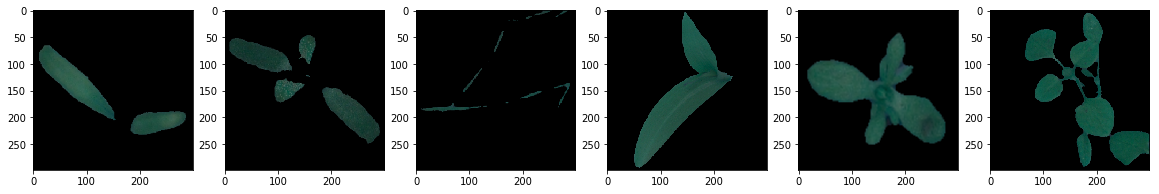

In [24]:
fig, axs = plt.subplots(1, 6, figsize=(20, 20))
axs[0].imshow(X_test[2])
axs[1].imshow(X_test[4])
axs[2].imshow(X_test[6])
axs[3].imshow(X_train[8])
axs[4].imshow(X_train[10])
axs[5].imshow(X_train[12])

In [26]:
print((X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape))

epochs = 30
batch_size = 64
start = time.time()

# Checkpointer that save best model only
checkpointer = ModelCheckpoint(filepath="./saved_models/inceptionV3_sgd_25e4lr_1e4dc_1e5f_30e_64b_masked_"+"epochs_"+ str(epochs) + "-batch_size_"+ str(batch_size) +"-weights-best.hdf5", 
                                monitor = "val_acc", verbose=1, save_best_only=True)

# Early Stop with patience = 7
earlystopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=7, verbose=0, mode='auto', baseline=None)

# Set up model history
history = History()

# Reduce learning rate with the factor of 0.85 and patience = 3
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=3, min_lr=0.0001)

# Setting up training log
training_log = CSVLogger('./training_log/inception_sgd_25e4lr_4e1dc_8e1f_4e1mlr_25e_64b_masked', separator=',', append=False)

# Fitting the model with callbacks = [checkpointer, earlystopper, history, lr_reduce, training_log]
Inception_Model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, earlystopper, history, lr_reduce, training_log], verbose=1)
        
end = time.time()
print (end-start)

((3800, 299, 299, 3), (950, 299, 299, 3), (3800, 12), (950, 12))
Train on 3800 samples, validate on 950 samples
Epoch 1/25
3800/3800 [==============================] - 164s 43ms/step - loss: 1.0339 - acc: 0.7103 - fscore: 0.5832 - val_loss: 0.3859 - val_acc: 0.8863 - val_fscore: 0.8809

Epoch 00001: val_acc improved from -inf to 0.88632, saving model to ./saved_models/inceptionV3_sgd_25e4lr_1e4dc_1e5f_30e_64b_masked_epochs_25-batch_size_64-weights-best.hdf5
Epoch 2/25
3800/3800 [==============================] - 138s 36ms/step - loss: 0.2158 - acc: 0.9358 - fscore: 0.9364 - val_loss: 0.2013 - val_acc: 0.9411 - val_fscore: 0.9375

Epoch 00002: val_acc improved from 0.88632 to 0.94105, saving model to ./saved_models/inceptionV3_sgd_25e4lr_1e4dc_1e5f_30e_64b_masked_epochs_25-batch_size_64-weights-best.hdf5
Epoch 3/25
3800/3800 [==============================] - 138s 36ms/step - loss: 0.1029 - acc: 0.9750 - fscore: 0.9748 - val_loss: 0.1672 - val_acc: 0.9463 - val_fscore: 0.9484

Epoch 000

In [27]:
print (Inception_Model.history.history)

{'val_acc': [0.8863157898501346, 0.9410526300731458, 0.9463157879678826, 0.9547368405994616, 0.9421052644127293, 0.9578947353363038, 0.9610526300731458, 0.9600000006274173, 0.9547368433600978, 0.9589473696758872, 0.9631578959916768, 0.9536842117811504, 0.9631578932310405, 0.9610526300731458, 0.9547368427326804, 0.9642105275706241, 0.9610526300731458, 0.9642105275706241, 0.9621052644127294, 0.9578947353363038, 0.9578947380969399, 0.961052632833782, 0.961052632833782], 'val_fscore': [0.8809095419080634, 0.937515581407045, 0.9484148621559143, 0.9563322060986569, 0.9451114832727533, 0.9612370273941442, 0.9633676241573534, 0.9613732445867438, 0.9571648947816146, 0.9583335734668531, 0.9656402441074974, 0.9571294260025024, 0.962829530992006, 0.9618689942359925, 0.9580648379576834, 0.9650867198642932, 0.9645047131337617, 0.9656187216859115, 0.9661307984904239, 0.9608368071756865, 0.9598169968002721, 0.9645145514136867, 0.9646058592043425], 'val_loss': [0.38593772831716033, 0.20133234996544688,

In [28]:
# Save Model history to json file
import json

hist = Inception_Model.history.history
del hist['lr']
json = json.dumps(hist)
f = open("./saved_model_history/inceptionV3_sgd_masked_25e4lr_1e4dc_1e8f_1e4mlr_30e_64b.json","w")
f.write(json)
f.close()

In [29]:
# Predict it on our Test set and print out some results
Inception_Model.load_weights('./saved_models/inceptionV3_sgd_25e4lr_1e4dc_1e8f_1e4mlr_30e_64b_masked.hdf5', by_name=True)
test_result = Inception_Model.predict(X_test, batch_size=32, verbose=1)
print(test_result)
print (len(test_result))

794/794 [==============================] - 13s 17ms/step
[[9.0218164e-05 8.8104993e-05 5.2143860e-05 ... 2.1851316e-05
  9.9939311e-01 3.4995250e-05]
 [6.6376805e-01 4.8430080e-05 2.2682661e-05 ... 2.5250989e-05
  4.2224103e-05 3.2041906e-04]
 [1.5543472e-05 3.5606768e-06 8.3694222e-06 ... 2.2499269e-06
  1.6255657e-06 9.9989223e-01]
 ...
 [3.8586961e-05 9.2527398e-04 9.9444371e-01 ... 1.6424728e-04
  8.5015548e-05 1.1411130e-04]
 [4.0567511e-06 1.2274656e-06 1.9353380e-05 ... 5.7787306e-06
  1.1824641e-05 2.1542826e-05]
 [2.1982591e-05 6.5478976e-05 4.7315822e-05 ... 6.2532308e-06
  4.8635789e-06 9.9672478e-01]]
794


In [31]:
# Create submission.csv accounting to the Kaggle required format
submission = pd.DataFrame()
file, species = [], [] 
for i in range(len(test_result)):
    file.append(test_df['file'][i].split('/')[2])
    idx = np.argmax(test_result[i], axis=None, out=None)
    species.append(categories[idx])
submission['file'] = file
submission['species'] = species

submission.to_csv('submission_inceptionV3_sgd_25e4lr_1e4dc_8e1f_1e4mlr_30e_64b.csv', sep=',', index= False)

In [32]:
# Create Error Analysis result and the result can be visualized by running error_analysis.py
valid_result = Inception_Model.predict(X_valid, batch_size=32, verbose=1)
error_analysis = pd.DataFrame()
valid_pred, valid_true = [], []

for i in range(len(valid_result)):
    idx_pred = np.argmax(valid_result[i], axis=None, out=None)
    idx_true = np.argmax(Y_valid[i], axis=None, out=None)
    valid_pred.append(categories[idx_pred])
    valid_true.append(categories[idx_true])
    
error_analysis['valid_pred'] = valid_pred
error_analysis['valid_true'] = valid_true

error_analysis.to_csv('error_analysis_inceptionV3_masked_sgd_25e4lr_1e4dc_8e1f_1e4mlr_30e_64b_.csv', sep=',', index= False)


950/950 [==============================] - 12s 13ms/step
